In [21]:
import pandas as pd
import numpy as np
%matplotlib inline

In [22]:
# READ DATA
full_df = pd.read_csv('full_data.csv')

# Figure 2: Less data

In [23]:
# make the dataset
unfrozen_blocks = 3

# HIGHERST ACC
by_list = ['target_ds', 'num_training_images', 'seed', 'source_eps', 'unfrozen_blocks'] 
# best_df = full_df.groupby(by=by_list).apply(lambda x: x[x['nat_prec1'] == max(x['nat_prec1'])]).reset_index(drop=True)

# HIGHEST EPOCH
group_by = ['target_ds', 'num_training_images', 'source_eps', 'seed', 'unfrozen_blocks']
best_df = full_df.groupby(by=group_by).apply(lambda x: x[x['epoch'] == max(x['epoch'])]).reset_index(drop=True)

inc = by_list + ['nat_prec1']
best_df = best_df.drop_duplicates(subset=inc).reset_index(drop=True)

# best_df = best_df[(best_df['seed']>=20000000)]
data = best_df[((best_df['source_eps'].isin([0,3]))) & (best_df['unfrozen_blocks'] == unfrozen_blocks)]

target_ds_map = {
    'cifar100': 'CIFAR-100',
    'cifar10' : 'CIFAR-10',
    'svhn'    : 'SVHN',
    'fmnist'  : 'FMNIST',
    'kmnist'  : 'KMNIST',
    'mnist'   : 'MNIST',
}

data.replace(target_ds_map, inplace=True)

# get delta
source_eps_3 = data[(data['source_eps'] == 3)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_0 = data[(data['source_eps'] == 0)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

delta_df = source_eps_3.copy()
delta_df['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_0['nat_prec1']
delta_df['source_eps'] = '3 minus 0'

/home/eecs/utrerf/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


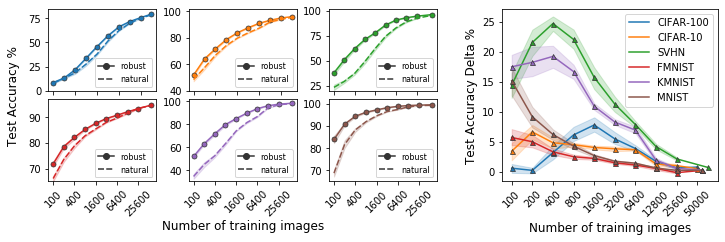

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib
from matplotlib import rc
import matplotlib.gridspec as gridspec
%matplotlib inline

axis_fontsize = 12
right = 1
bottom = .1
top = .7

xticks = np.sort(data[data['target_ds'] == 'CIFAR-10']['num_training_images'].unique())
target_datasets = ['CIFAR-100', 'CIFAR-10', 'SVHN', 'FMNIST', 'KMNIST', 'MNIST']

fig = plt.figure(constrained_layout=False)
spec1 = fig.add_gridspec(ncols=3, nrows=2, left=0.1, right=right, bottom=bottom, top=top,
                         wspace=.3, hspace=.1)


palette = sns.color_palette(n_colors=len(target_datasets))

y_lims = [
    (0, 85),
    (40, 102),
    (20, 102),
    (65, 97),
    (30, 102),
    (65, 102)
]

for i, target in enumerate(target_datasets):
    ax = fig.add_subplot(spec1[i//3, i%3])
   
    sns.lineplot(x='num_training_images', y='nat_prec1', style='source_eps', style_order=[3, 0],
                 data=data[data['target_ds']== target], color=palette[i],
                 ax = ax, markers=['o'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

    ax.set_xscale('log', basex=2)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(xticks[::2])
    
    ax.tick_params(axis='x', labelrotation=45)
    ax.get_yaxis().get_label().set_visible(False)
    ax.get_xaxis().get_label().set_visible(False)
    ax.set_ylim(y_lims[i])
    handles, labels = ax.get_legend_handles_labels()

    ax.legend(labels=['robust', 'natural'], handles=handles[1:5], loc='lower right', fontsize=8).set_zorder(0)

    
#     if i != len(target_datasets)-1:
#         ax.get_legend().remove()
    
    if i in range(3):
        ax.xaxis.set_ticklabels([])

left = right+.15
right2 = left + .5

spec2 = fig.add_gridspec(ncols=2, nrows=2, left=left, right=right2, bottom=bottom, top=top,
                         wspace=0)
ax = fig.add_subplot(spec2[:, :])

sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='target_ds', hue_order=target_datasets, 
             data=delta_df[delta_df['unfrozen_blocks'] == unfrozen_blocks], ax = ax,
             style='source_eps', markers=['^'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
# ax.set_title('Robust minus natural model accuracy')
ax.set_ylabel('Test Accuracy Delta %', fontsize=axis_fontsize)
ax.set_xlabel('Number of training images', fontsize=axis_fontsize)
# ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)


handles, labels = ax.get_legend_handles_labels()
    
labels[0] = 'Target\ndataset'
labels[7] = 'Source $\epsilon$'
ax.legend(handles=handles[1:-2], labels=labels[1:-2]);

fig.text(0.02, (top+.1)/2, 'Test Accuracy %', ha='center', va='center', 
         rotation='vertical', fontsize=axis_fontsize)
fig.text((right+.1)/2, -0.055, 'Number of training images', ha='center', va='center', 
         rotation='horizontal', fontsize=axis_fontsize)


# plt.tight_layout()
plt.savefig(f'plots/less_images.pdf', dpi=500, bbox_inches='tight')

# Figure 3: Learn faster

In [25]:
# make the dataset
unfrozen_blocks = 3
epoch_list = [11, 21, 41, 81, 150]

# epoch_list = [21, 41, 81, 100]

by_list = ['target_ds', 'num_training_images', 'seed', 'source_eps', 'unfrozen_blocks', 'epoch'] 
best_df = full_df[(full_df['num_training_images'] == 3200) & (full_df['epoch'].isin(epoch_list))]


best_df = best_df.groupby(by=by_list).apply(lambda x: x[x['nat_prec1'] == max(x['nat_prec1'])]).reset_index(drop=True)
best_df = best_df.groupby(by=by_list).apply(lambda x: x[x['epoch'] == max(x['epoch'])]).reset_index(drop=True)

inc = by_list + ['nat_prec1']
best_df = best_df.drop_duplicates(subset=inc).reset_index(drop=True)

# best_df = best_df[(best_df['seed']>=20000000)]
data = best_df[((best_df['source_eps'].isin([0,3]))) & (best_df['unfrozen_blocks'] == unfrozen_blocks)]

target_ds_map = {
    'cifar100': 'CIFAR-100',
    'cifar10' : 'CIFAR-10',
    'svhn'    : 'SVHN',
    'fmnist'  : 'FMNIST',
    'kmnist'  : 'KMNIST',
    'mnist'   : 'MNIST',
}

data.replace(target_ds_map, inplace=True)

# get delta
source_eps_3 = data[(data['source_eps'] == 3)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_0 = data[(data['source_eps'] == 0)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

print(len(source_eps_3))
print(len(source_eps_0))

delta_df = source_eps_3.copy()
delta_df['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_0['nat_prec1']
delta_df['source_eps'] = '3 minus 0'


300
300


/home/eecs/utrerf/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


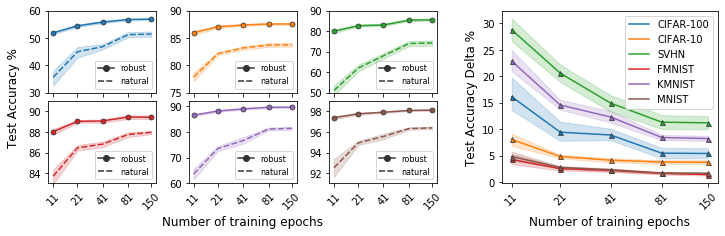

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib
from matplotlib import rc
import matplotlib.gridspec as gridspec
%matplotlib inline

xticks = epoch_list
target_datasets = ['CIFAR-100', 'CIFAR-10', 'SVHN', 'FMNIST', 'KMNIST', 'MNIST']

axis_fontsize = 12
right = 1
bottom = .1
top = .7

fig = plt.figure(constrained_layout=False)
spec1 = fig.add_gridspec(ncols=3, nrows=2, left=0.1, right=right, bottom=bottom, top=top,
                         wspace=.3, hspace=.1)

palette = sns.color_palette(n_colors=len(target_datasets))

y_lims = [
    (30, 60),
    (75, 90),
    (50, 90),
    (83, 91),
    (60, 92),
    (91, 99)
]

for i, target in enumerate(target_datasets):
    ax = fig.add_subplot(spec1[i//3, i%3])
   
    sns.lineplot(x='epoch', y='nat_prec1', style='source_eps', style_order=[3, 0],
                 data=data[data['target_ds']== target], color=palette[i],
                 ax = ax, markers=['o'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

    ax.set_xscale('log', basex=2)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(xticks)
    
    ax.tick_params(axis='x', labelrotation=45)
    ax.get_yaxis().get_label().set_visible(False)
    ax.get_xaxis().get_label().set_visible(False)
    ax.legend(['robust', 'natural'], loc='lower right')
    ax.set_ylim(y_lims[i])
    handles, labels = ax.get_legend_handles_labels()

    ax.legend(labels=['robust', 'natural'], handles=handles[1:5], loc='lower right', fontsize=8).set_zorder(0)
    
    if i in range(3):
        ax.xaxis.set_ticklabels([])
        
    if i == 3:
        ax.set_yticks([84,86,88,90])


# DELTA
left = right+.15
right2 = left + .5

spec2 = fig.add_gridspec(ncols=2, nrows=2, left=left, right=right2, bottom=bottom, top=top,
                         wspace=0)
ax = fig.add_subplot(spec2[:, :])

sns.lineplot(x='epoch', y='nat_prec1_delta', hue='target_ds', hue_order=target_datasets, 
             data=delta_df[delta_df['unfrozen_blocks'] == unfrozen_blocks], ax = ax,
             style='source_eps', markers=['^'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
# ax.set_title('Robust minus natural model accuracy')
ax.set_ylabel('Test Accuracy Delta %', fontsize=axis_fontsize)
ax.set_xlabel('Number of training epochs', fontsize=axis_fontsize)
# ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)

handles, labels = ax.get_legend_handles_labels()
    
labels[0] = 'Target\ndataset'
labels[7] = 'Source $\epsilon$'
ax.legend(handles=handles[1:-2], labels=labels[1:-2]);

fig.text(0.02, (top+.1)/2, 'Test Accuracy %', ha='center', va='center', 
         rotation='vertical', fontsize=axis_fontsize)
fig.text((right+.1)/2, -0.035, 'Number of training epochs', ha='center', va='center', 
         rotation='horizontal', fontsize=axis_fontsize)


# plt.tight_layout()
plt.savefig(f'plots/less_epochs.pdf', dpi=500, bbox_inches='tight')

# Figure 4: How many blocks to fine-tune?

In [27]:
# make the dataset
eps = 8

by_list = ['target_ds', 'num_training_images', 'seed', 'source_eps', 'unfrozen_blocks'] 
best_df = full_df.groupby(by=by_list).apply(lambda x: x[x['nat_prec1'] == max(x['nat_prec1'])]).reset_index(drop=True)
# best_df = best_df.groupby(by=by_list).apply(lambda x: x[x['epoch'] == max(x['epoch'])]).reset_index(drop=True)

inc = by_list + ['nat_prec1']
best_df = best_df.drop_duplicates(subset=inc).reset_index(drop=True)

# best_df = best_df[(best_df['seed']>=20000000)]
data = best_df[best_df['source_eps'] == eps]

target_ds_map = {
    'cifar100': 'CIFAR-100',
    'cifar10' : 'CIFAR-10',
    'svhn'    : 'SVHN',
    'fmnist'  : 'FMNIST',
    'kmnist'  : 'KMNIST',
    'mnist'   : 'MNIST',
}

data.replace(target_ds_map, inplace=True)

# get delta
source_ub_0 = data[(data['unfrozen_blocks'] == 0)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_ub_1 = data[(data['unfrozen_blocks'] == 1)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_ub_3 = data[(data['unfrozen_blocks'] == 3)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_ub_9 = data[(data['unfrozen_blocks'] == 6)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)


print(len(source_ub_0))
print(len(source_ub_1))
print(len(source_ub_3))
print(len(source_ub_9))

delta_df1 = source_ub_3.copy()
delta_df1['nat_prec1_delta'] =  source_ub_3['nat_prec1'] - source_ub_0['nat_prec1'] 
delta_df1['unfrozen_blocks'] = '3 minus 0'

delta_df2 = source_ub_3.copy()
delta_df2['nat_prec1_delta'] =  source_ub_3['nat_prec1'] - source_ub_1['nat_prec1'] 
delta_df2['unfrozen_blocks'] = '3 minus 1'

delta_df3 = source_ub_3.copy()
delta_df3['nat_prec1_delta'] =  source_ub_3['nat_prec1'] - source_ub_9['nat_prec1']
delta_df3['unfrozen_blocks'] = '3 minus 9'

486
486
486
486


/home/eecs/utrerf/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [28]:
import seaborn as sns

palettes = []

palette_names = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples']

for p in palette_names:
    palettes.append(sns.color_palette(p, n_colors=4))
    
palettes.append(sns.light_palette((32, 90, 40), input="husl", n_colors=4))

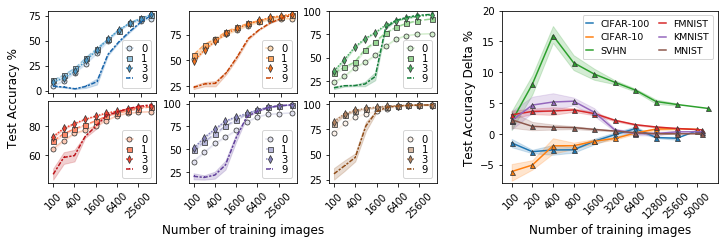

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib
from matplotlib import rc
import matplotlib.gridspec as gridspec
import matplotlib.legend as mlegend
%matplotlib inline

# plot just for markers

# tempfig, ax = plt.subplots()

# sns.lineplot(x='num_training_images', y='nat_prec1', hue='unfrozen_blocks',style='unfrozen_blocks', 
#              data=data[data['target_ds']== target], palette=sns.dark_palette((0, 0, 90), input="husl", n_colors=4)[::-1],
#              ax = ax, markers=['o', 's', '^', ','], markersize=5, markeredgecolor=sns.xkcd_rgb["black"]
#             )
# # legend = ax.legend([0, 1, 3, 9])

# print(dir(legend))

# handles, labels = ax.get_legend_handles_labels()
# print(handles)
# print(labels)

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, [0,1,3,9])

# plt.close(tempfig)


xticks = [11, 21, 41, 81, 150]
target_datasets = ['CIFAR-100', 'CIFAR-10', 'SVHN', 'FMNIST', 'KMNIST', 'MNIST']

axis_fontsize = 12
right = 1
bottom = .1
top = .7

fig = plt.figure(constrained_layout=False)
spec1 = fig.add_gridspec(ncols=3, nrows=2, left=0.1, right=right, bottom=bottom, top=top,
                         wspace=.3, hspace=.1)


palette = sns.color_palette(n_colors=len(target_datasets))


y_lims = [
    (30, 60),
    (75, 90),
    (50, 90),
    (83, 91),
    (60, 92),
    (91, 99)
]
    
   
xticks = np.sort(data[data['target_ds'] == 'CIFAR-10']['num_training_images'].unique())
target_datasets = ['CIFAR-100', 'CIFAR-10', 'SVHN', 'FMNIST', 'KMNIST', 'MNIST']

palette = sns.color_palette(n_colors=len(target_datasets))
palette = sns.color_palette(n_colors=4)
palette = sns.diverging_palette(240, 10, n=4, center="dark")


for i, target in enumerate(target_datasets):
    ax = fig.add_subplot(spec1[i//3, i%3])
   
    sns.lineplot(x='num_training_images', y='nat_prec1', hue='unfrozen_blocks',style='unfrozen_blocks', 
                 data=data[data['target_ds']== target], palette=palettes[i],
                 ax = ax, markers=['o', 's', 'd', ','], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"]
                )

    ax.set_xscale('log', basex=2)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(xticks[::2])
    
    ax.tick_params(axis='x', labelrotation=45)
    ax.get_yaxis().get_label().set_visible(False)
    ax.get_xaxis().get_label().set_visible(False)
    ax.legend([0,1,3,9], loc='lower right', labelspacing=0, handlelength=.7)
#     ax.set_title(target)
#     if i != len(target_datasets)-1:
#         ax.get_legend().remove()
    if i in range(3):
        ax.xaxis.set_ticklabels([])

# DELTA

left = right+.15
right2 = left + .5

spec2 = fig.add_gridspec(ncols=2, nrows=2, left=left, right=right2, bottom=bottom, top=top,
                         wspace=0)
ax = fig.add_subplot(spec2[:, :])

sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='target_ds', hue_order=target_datasets, 
             data=delta_df2, ax = ax,
             style='source_eps', markers=['^'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
# ax.set_title('3 vs 1 Fine-tuned blocks')
ax.set_ylabel('Test Accuracy Delta %', fontsize=axis_fontsize)
ax.set_xlabel('Number of training images', fontsize=axis_fontsize)
# ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim((-8,20))

handles, labels = ax.get_legend_handles_labels()
    
labels[0] = 'Target\ndataset'
labels[7] = 'Source $\epsilon$'
ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=2, loc='upper right', 
          columnspacing=1, handlelength=.7, fontsize=9.5);

fig.text(0.02, (top+.1)/2, 'Test Accuracy %', ha='center', va='center', 
         rotation='vertical', fontsize=axis_fontsize)
fig.text((right+.1)/2, -0.06, 'Number of training images', ha='center', va='center', 
         rotation='horizontal', fontsize=axis_fontsize)


# plt.tight_layout()
plt.savefig(f'plots/ft_blocks_{eps}.pdf', dpi=500, bbox_inches='tight')

# Figure 5: Which constraint

In [30]:
# make the dataset
unfrozen_blocks = 3

by_list = ['target_ds', 'num_training_images', 'seed', 'source_eps', 'unfrozen_blocks'] 
best_df = full_df.groupby(by=by_list).apply(lambda x: x[x['nat_prec1'] == max(x['nat_prec1'])]).reset_index(drop=True)
# best_df = best_df.groupby(by=by_list).apply(lambda x: x[x['epoch'] == max(x['epoch'])]).reset_index(drop=True)

inc = by_list + ['nat_prec1']
best_df = best_df.drop_duplicates(subset=inc).reset_index(drop=True)

# best_df = best_df[(best_df['seed']>=20000000)]
data = best_df[best_df['unfrozen_blocks'] == 1]
# data = data[best_df['source_eps']]

target_ds_map = {
    'cifar100': 'CIFAR-100',
    'cifar10' : 'CIFAR-10',
    'svhn'    : 'SVHN',
    'fmnist'  : 'FMNIST',
    'kmnist'  : 'KMNIST',
    'mnist'   : 'MNIST',
}

data.replace(target_ds_map, inplace=True)

# get delta
source_eps_0 = data[(data['source_eps'] == 0)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_3 = data[(data['source_eps'] == 3)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_4 = data[(data['source_eps'] == 4)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_8 = data[(data['source_eps'] == 8)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

print(len(source_eps_0))
print(len(source_eps_3))
print(len(source_eps_4))
print(len(source_eps_8))


delta_df0 = source_eps_3.copy()
delta_df0['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_0['nat_prec1'] 
delta_df0['unfrozen_blocks'] = '3 minus 0'

delta_df1 = source_eps_3.copy()
delta_df1['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_4['nat_prec1'] 
delta_df1['unfrozen_blocks'] = '3 minus 4'

delta_df2 = source_eps_3.copy()
delta_df2['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_8['nat_prec1'] 
delta_df2['unfrozen_blocks'] = '3 minus 8'

delta_df3 = source_eps_4.copy()
delta_df3['nat_prec1_delta'] =  source_eps_4['nat_prec1'] - source_eps_8['nat_prec1'] 
delta_df3['unfrozen_blocks'] = '4 minus 8'


486
486
486
486


/home/eecs/utrerf/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


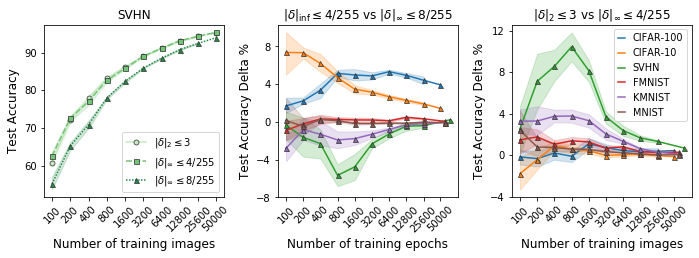

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib
from matplotlib import rc
import matplotlib.gridspec as gridspec
import matplotlib.legend as mlegend
%matplotlib inline

xticks = [11, 21, 41, 81, 150]

axis_fontsize = 12


fig = plt.figure(constrained_layout=False)



y_lims = [
    (30, 60),
    (75, 90),
    (50, 90),
    (83, 91),
    (60, 92),
    (91, 99)
]
    
   
xticks = np.sort(data[data['target_ds'] == 'CIFAR-10']['num_training_images'].unique())
target_datasets = ['CIFAR-100', 'SVHN']
full_target_datasets = ['CIFAR-100', 'CIFAR-10', 'SVHN', 'FMNIST', 'KMNIST', 'MNIST']

palette = sns.color_palette(n_colors=len(target_datasets))

# DELTA

left = .1
bottom = .1
top = .7
right = 1.6

spec2 = fig.add_gridspec(ncols=3, nrows=1, left=left, right=right, bottom=bottom, top=top,
                         wspace=.3)

ax = fig.add_subplot(spec2[0, 0])

sns.lineplot(x='num_training_images', y='nat_prec1', hue='source_eps',style='source_eps', 
             data=data[(data['target_ds']=='CIFAR-10') & (data['source_eps']!=0)], 
             palette=sns.color_palette('Greens', n_colors=3),
             ax = ax, markers=['o', 's', '^', '.'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"]
            )

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
# ax.set_yticks(range(-4,14,4))
ax.set_title('SVHN')
ax.set_ylabel('Test Accuracy', fontsize=axis_fontsize)
ax.set_xlabel('Number of training images', fontsize=axis_fontsize)
# ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)
ax.legend(['$\|\delta\|_2 \leq 3$', '$\|\delta\|_\infty \leq 4/255$', '$\|\delta\|_\infty \leq 8/255$'])

# handles, labels = ax.get_legend_handles_labels()
    
# labels[0] = 'Target\ndataset'
# labels[7] = 'Source $\epsilon$'
# ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=1, loc='upper right', 
#           columnspacing=1, handlelength=.7, fontsize=9.7);



ax = fig.add_subplot(spec2[0, 1])

sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='target_ds', hue_order=full_target_datasets, 
             data=delta_df3, ax = ax,
             style='source_eps', markers=['^'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
ax.set_yticks(range(-8, 10, 4))
ax.set_title('$\|\delta\|_\inf \leq 4/255$ vs $\|\delta\|_\infty \leq 8/255$')
ax.set_ylabel('Test Accuracy Delta %', fontsize=axis_fontsize)
ax.set_xlabel('Number of training epochs', fontsize=axis_fontsize)
# ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)
# ax.xaxis.set_ticklabels([])

handles, labels = ax.get_legend_handles_labels()
    
labels[0] = 'Target\ndataset'
labels[7] = 'Source $\epsilon$'
ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=2, loc='lower right', 
          columnspacing=1, handlelength=.7, fontsize=9.7);

ax.get_legend().remove()


ax = fig.add_subplot(spec2[0, 2])

sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='target_ds', hue_order=full_target_datasets, 
             data=delta_df1, ax = ax,
             style='source_eps', markers=['^'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
ax.set_yticks(range(-4,14,4))
ax.set_title('$\|\delta\|_2 \leq 3$ vs $\|\delta\|_\infty \leq 4/255$')
ax.set_ylabel('Test Accuracy Delta %', fontsize=axis_fontsize)
ax.set_xlabel('Number of training images', fontsize=axis_fontsize)
# ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)


handles, labels = ax.get_legend_handles_labels()
    
labels[0] = 'Target\ndataset'
labels[7] = 'Source $\epsilon$'
ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=1, loc='upper right', 
          columnspacing=1, handlelength=.7, fontsize=9.7);

# fig.text(0.02, (top+.1)/2, 'Test Accuracy %', ha='center', va='center', 
#          rotation='vertical', fontsize=axis_fontsize)
# fig.text((right+.1)/2, -0.06, 'Number of training epochs', ha='center', va='center', 
#          rotation='horizontal', fontsize=axis_fontsize)


# plt.tight_layout()
plt.savefig(f'plots/constraint.pdf', dpi=500, bbox_inches='tight')

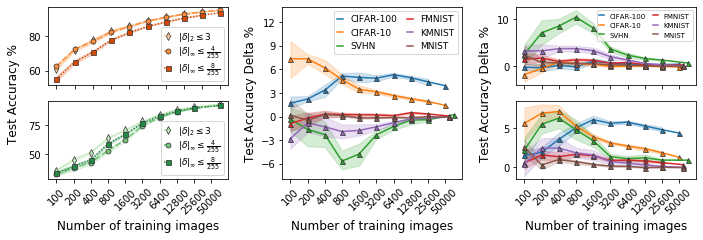

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib
from matplotlib import rc
import matplotlib.gridspec as gridspec
import matplotlib.legend as mlegend
%matplotlib inline

xticks = [11, 21, 41, 81, 150]

axis_fontsize = 12


fig = plt.figure(constrained_layout=False)



y_lims = [
    (30, 60),
    (75, 90),
    (50, 90),
    (83, 91),
    (60, 92),
    (91, 99)
]
    
   
xticks = np.sort(data[data['target_ds'] == 'CIFAR-10']['num_training_images'].unique())
target_datasets = ['CIFAR-100', 'SVHN']
full_target_datasets = ['CIFAR-100', 'CIFAR-10', 'SVHN', 'FMNIST', 'KMNIST', 'MNIST']

palette = sns.color_palette(n_colors=len(target_datasets))

# DELTA

left = .1
bottom = .1
top = .7
right = 1.6

spec2 = fig.add_gridspec(ncols=3, nrows=2, left=left, right=right, bottom=bottom, top=top,
                         wspace=.3)

ax = fig.add_subplot(spec2[0, 0])

markers = ['d', 'o', 's']

sns.lineplot(x='num_training_images', y='nat_prec1', hue='source_eps',style='source_eps', 
             data=data[(data['target_ds']=='CIFAR-10') & (data['source_eps']!=0)], 
             palette=sns.color_palette('Oranges', n_colors=3),
             ax = ax, markers=markers, markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"]
            )

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.set_xticks(xticks)
ax.set_xticks(xticks)
# ax.set_yticks(range(-4,14,4))
# ax.set_title('CIFAR-10')
# ax.set_ylabel('Test Accuracy', fontsize=axis_fontsize)
# ax.set_xlabel('Number of training images', fontsize=axis_fontsize)
ax.get_yaxis().get_label().set_visible(False)
ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)
ax.legend(['$\|\delta\|_2 \leq 3$', 
           r'$\|\delta\|_\infty \leq \frac{4}{255}$', 
           r'$\|\delta\|_\infty \leq \frac{8}{255}$'],
         labelspacing=0, handlelength=.7, fontsize=9)
ax.xaxis.set_ticklabels([])

# handles, labels = ax.get_legend_handles_labels()
    
# labels[0] = 'Target\ndataset'
# labels[7] = 'Source $\epsilon$'
# ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=1, loc='upper right', 
#           columnspacing=1, handlelength=.7, fontsize=9.7);

ax = fig.add_subplot(spec2[1, 0])

sns.lineplot(x='num_training_images', y='nat_prec1', hue='source_eps',style='source_eps', 
             data=data[(data['target_ds']=='SVHN') & (data['source_eps']!=0)], 
             palette=sns.color_palette('Greens', n_colors=3),
             ax = ax, markers=markers, markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"]
            )

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
# ax.set_yticks(range(-4,14,4))
# ax.set_title('SVHN')
# ax.set_ylabel('Test Accuracy', fontsize=axis_fontsize)
ax.set_xlabel('Number of training images', fontsize=axis_fontsize)
ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)
ax.legend(['$\|\delta\|_2 \leq 3$', 
           r'$\|\delta\|_\infty \leq \frac{4}{255}$', 
           r'$\|\delta\|_\infty \leq \frac{8}{255}$'],
         labelspacing=0, handlelength=.7, fontsize=9)

# handles, labels = ax.get_legend_handles_labels()
    
# labels[0] = 'Target\ndataset'
# labels[7] = 'Source $\epsilon$'
# ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=1, loc='upper right', 
#           columnspacing=1, handlelength=.7, fontsize=9.7);

ax = fig.add_subplot(spec2[:2, 1])

sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='target_ds', hue_order=full_target_datasets, 
             data=delta_df3, ax = ax,
             style='source_eps', markers=['^'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
ax.set_yticks(range(-6,14,3))
ax.set_ylim((-8, 14))
# ax.set_title(r'$\epsilon = \frac{4}{255}$  vs  $\epsilon = \frac{8}{255}$')
ax.set_ylabel('Test Accuracy Delta %', fontsize=axis_fontsize)
ax.set_xlabel('Number of training images', fontsize=axis_fontsize)
# ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)


handles, labels = ax.get_legend_handles_labels()
    
labels[0] = 'Target\ndataset'
labels[7] = 'Source $\epsilon$'
ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=2, loc='upper right', 
          columnspacing=1, handlelength=.7, fontsize=9);
# ax.get_legend().remove()


ax = fig.add_subplot(spec2[0, 2])

sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='target_ds', hue_order=full_target_datasets, 
             data=delta_df1, ax = ax,
             style='source_eps', markers=['^'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
# ax.set_yticks(range(-8, 14, 4))
# ax.set_title(r'$\|\delta\|_2$  vs  $\|\delta\|_\infty$')
ax.set_ylabel('Test Accuracy Delta %', fontsize=axis_fontsize)
ax.set_xlabel('Number of training epochs', fontsize=axis_fontsize)
ax.get_yaxis().get_label().set_visible(False)
ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)
ax.xaxis.set_ticklabels([])


handles, labels = ax.get_legend_handles_labels()
    
labels[0] = 'Target\ndataset'
labels[7] = 'Source $\epsilon$'
ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=2, loc='upper right', 
          columnspacing=1, handlelength=.7, fontsize=7);
# ax.get_legend().remove()

ax = fig.add_subplot(spec2[1, 2])

sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='target_ds', hue_order=full_target_datasets, 
             data=delta_df2, ax = ax,
             style='source_eps', markers=['^'], markersize=5, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
# ax.set_yticks(range(-8, 14, 4))
# ax.set_title(r'$\|\delta\|_\infty \leq \frac{4}{255}$  vs  $\|\delta\|_\infty \leq \frac{8}{255}$')
ax.set_ylabel('Test Accuracy Delta %', fontsize=axis_fontsize)
ax.set_xlabel('Number of training images', fontsize=axis_fontsize)
ax.get_yaxis().get_label().set_visible(False)
# ax.get_xaxis().get_label().set_visible(False)
ax.tick_params(axis='x', labelrotation=45)
# ax.xaxis.set_ticklabels([])
# ax.set_ylim((-2, 12))

handles, labels = ax.get_legend_handles_labels()
    
labels[0] = 'Target\ndataset'
labels[7] = 'Source $\epsilon$'
ax.legend(handles=handles[1:-2], labels=labels[1:-2], ncol=3, loc='upper right', 
          columnspacing=1, handlelength=.7, fontsize=7);
ax.get_legend().remove()


fig.text(0.02, (top+.1)/2, 'Test Accuracy %', ha='center', va='center', 
         rotation='vertical', fontsize=axis_fontsize)

fig.text(1.111, (top+.1)/2, 'Test Accuracy Delta %', ha='center', va='center', 
         rotation='vertical', fontsize=axis_fontsize)
# fig.text((right+.1)/2, -0.06, 'Number of training epochs', ha='center', va='center', 
#          rotation='horizontal', fontsize=axis_fontsize)


# plt.tight_layout()
plt.savefig(f'plots/constraint.pdf', dpi=500, bbox_inches='tight')

# Summary of results table

In [33]:
table_2 = full_df[full_df['unfrozen_blocks'].isin([3])]

group_by = ['target_ds', 'num_training_images', 'source_eps', 'seed', 'unfrozen_blocks']
table_2 = table_2.groupby(by=group_by).apply(lambda x: x[x['epoch'] == max(x['epoch'])]).reset_index(drop=True)

group_by = ['target_ds', 'num_training_images', 'source_eps', 'unfrozen_blocks']
table_2 = table_2.groupby(by=group_by).mean()

table_2.pivot_table(values='nat_prec1', index=['num_training_images', 'target_ds'], columns=['source_eps']).to_csv('tables/summary_table.csv')